# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                        
Sample_196  Q8N9I0                                   17.806
Sample_059  F8W1B7;P50281                            15.651
Sample_130  Q9HC57                                   14.409
Sample_008  Q12797;Q12797-10                         12.388
Sample_083  A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3   13.980
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                                           
Sample_105  Q15121;Q15121-2                                              9.543
Sample_182  A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0-2;Q7Z6L0-3   13.846
Sample_136  Q96RW7;Q96RW7-2                                              9.831
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.456
            A0A075B6Q5                 12.472
            A0A075B6R2                 12.577
            A0A075B6S5                 12.076
            A0A087WSY4                 12.226
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   14.285
            Q9UI40;Q9UI40-2            13.351
            Q9UIW2                     13.276
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.384
            Q9UP79                     11.549
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,11.509,15.050,16.842,19.863,14.209,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.528,19.067,...,15.528,15.576,11.584,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.099,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.001,17.705,17.039,13.636,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.045,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,13.077,15.345,17.084,18.708,14.249,19.433,10.990,9.032
Sample_207,15.739,16.877,15.469,16.898,14.931,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.590,13.839,13.593,14.480,12.078,13.035,13.395,13.711,13.085,13.387
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.774,19.067,16.127,...,12.373,14.461,13.549,12.824,11.294,12.722,13.924,13.294,12.814,13.043
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.444,12.820,12.494,13.127,13.808,13.826,12.089,13.079,12.998,12.642
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.680,12.356,12.419,12.024,13.626,13.885,14.031,12.541,13.555,13.910
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.644,12.567,12.319,13.210,12.048,12.767,12.777,11.761,13.993,12.033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.227,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 308.47it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.91it/s]

100%|██████████| 2/2 [00:00<00:00,  7.87it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.06it/s]

100%|██████████| 3/3 [00:00<00:00,  4.27it/s]

100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.51it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.65it/s]

100%|██████████| 4/4 [00:00<00:00,  3.63it/s]

100%|██████████| 4/4 [00:00<00:00,  4.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.11it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.12it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.22it/s]

100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.95it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.77it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.36it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.82it/s]

100%|██████████| 6/6 [00:01<00:00,  2.62it/s]

100%|██████████| 6/6 [00:01<00:00,  3.00it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.25it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.25it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.69it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.63it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.63it/s]

100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.41it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.46it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.97it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.76it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.67it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.60it/s]

100%|██████████| 8/8 [00:02<00:00,  2.84it/s]

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.94it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.73it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.08it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.79it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.62it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.77it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.95it/s]

100%|██████████| 9/9 [00:02<00:00,  2.94it/s]

100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.42it/s]

 30%|███       | 3/10 [00:00<00:02,  3.48it/s]

 40%|████      | 4/10 [00:01<00:02,  2.96it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.73it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.53it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.65it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.76it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.90it/s]

100%|██████████| 10/10 [00:03<00:00,  3.13it/s]

100%|██████████| 10/10 [00:03<00:00,  3.00it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.61it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.14it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.24it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.89it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.77it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.78it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.89it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.25it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.24it/s]

100%|██████████| 11/11 [00:03<00:00,  3.21it/s]

100%|██████████| 11/11 [00:03<00:00,  3.21it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.83it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.53it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.92it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.69it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.54it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.62it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.71it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.89it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.02it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.13it/s]

100%|██████████| 12/12 [00:03<00:00,  3.16it/s]

100%|██████████| 12/12 [00:03<00:00,  3.01it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.97it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.38it/s]

 31%|███       | 4/13 [00:01<00:02,  3.02it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.77it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.65it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.59it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.66it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.93it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.37it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.47it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.59it/s]

100%|██████████| 13/13 [00:03<00:00,  3.89it/s]

100%|██████████| 13/13 [00:04<00:00,  3.25it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.64it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.23it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.82it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.62it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.79it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.92it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.88it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.08it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.20it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.21it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.28it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.23it/s]

100%|██████████| 14/14 [00:04<00:00,  3.33it/s]

100%|██████████| 14/14 [00:04<00:00,  3.13it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.65it/s]

 20%|██        | 3/15 [00:00<00:03,  3.51it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.15it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.17it/s]

 40%|████      | 6/15 [00:01<00:02,  3.47it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.21it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.21it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.25it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.21it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.30it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.36it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.40it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.32it/s]

100%|██████████| 15/15 [00:04<00:00,  3.47it/s]

100%|██████████| 15/15 [00:04<00:00,  3.37it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.066 0.029          0.746 0.369       0.104   
2             0.005 0.005      0.054 0.023          0.681 0.126       0.489   
3             0.005 0.004      0.053 0.025          0.724 0.089       0.689   
4             0.006 0.005      0.062 0.023          0.704 0.090       0.688   
5             0.005 0.004      0.050 0.022          0.739 0.096       0.701   
6             0.004 0.002      0.040 0.011          0.790 0.079       0.761   
7             0.004 0.002      0.042 0.012          0.811 0.086       0.781   
8             0.004 0.000      0.046 0.017          0.808 0.087       0.778   
9             0.004 0.002      0.045 0.015          0.800 0.082       0.780   
10            0.004 0.003      0.042 0.016          0.809 0.074       0.817   
11            0.004 0.001      0.045 0.017          0.808 0.075       0.812   
12            0.005 0.005      0.045 0.018          0.799 0.075       0.810   
13            0.006 0.004      0.051 0.019          0.798 0.075       0.807   
14            0.006 0.005      0.055 0.020          0.812 0.074       0.797   
15            0.006 0.005      0.064 0.020          0.817 0.079       0.787   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.175 0.125                  0.545 0.039        0.845   
2          0.123   0.559 0.097                  0.656 0.065        0.709   
3          0.108   0.701 0.080                  0.747 0.066        0.849   
4          0.101   0.692 0.080                  0.736 0.068        0.847   
5          0.126   0.714 0.094                  0.759 0.074        0.856   
6          0.104   0.771 0.071                  0.805 0.059        0.883   
7          0.090   0.792 0.069                  0.822 0.059        0.888   
8          0.088   0.790 0.070                  0.820 0.060        0.886   
9          0.096   0.787 0.073                  0.818 0.061        0.890   
10         0.092   0.809 0.060                  0.837 0.052        0.903   
11         0.096   0.805 0.060                  0.834 0.052        0.900   
12         0.099   0.800 0.061                  0.829 0.053        0.899   
13         0.100   0.798 0.060                  0.828 0.052        0.898   
14         0.087   0.801 0.059                  0.830 0.050        0.905   
15         0.088   0.798 0.061                  0.828 0.050        0.904   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.821 0.088        210.000 0.000  
2          0.089                  0.653 0.100        210.000 0.000  
3          0.064                  0.818 0.077        210.000 0.000  
4          0.063                  0.815 0.073        210.000 0.000  
5          0.060                  0.821 0.077        210.000 0.000  
6          0.056                  0.864 0.062        210.000 0.000  
7          0.058                  0.877 0.060        210.000 0.000  
8          0.059                  0.876 0.061        210.000 0.000  
9          0.057                  0.883 0.058        210.000 0.000  
10         0.050                  0.896 0.048        210.000 0.000  
11         0.052                  0.890 0.053        210.000 0.000  
12         0.051                  0.891 0.050        210.000 0.000  
13         0.051                  0.891 0.050        210.000 0.000  
14         0.051                  0.899 0.049        210.000 0.000  
15         0.051                  0.898 0.048 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 458.29it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.67it/s]

100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.93it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.96it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.24it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.18it/s]

100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.63it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.81it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.11it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.79it/s]

100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.78it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.91it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.40it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.92it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.97it/s]

100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.26it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.89it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.72it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.61it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.59it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.69it/s]

100%|██████████| 8/8 [00:02<00:00,  3.66it/s]

100%|██████████| 8/8 [00:02<00:00,  3.86it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.95it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.05it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.63it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.32it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.24it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.35it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.40it/s]

100%|██████████| 9/9 [00:02<00:00,  3.56it/s]

100%|██████████| 9/9 [00:02<00:00,  3.56it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.76it/s]

 30%|███       | 3/10 [00:00<00:02,  3.23it/s]

 40%|████      | 4/10 [00:01<00:01,  3.10it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.26it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.41it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.04it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.06it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.07it/s]

100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

100%|██████████| 10/10 [00:03<00:00,  3.19it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.31it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.16it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.79it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.60it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.97it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.73it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.71it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.71it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.62it/s]

100%|██████████| 11/11 [00:03<00:00,  2.65it/s]

100%|██████████| 11/11 [00:03<00:00,  3.02it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.79it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.28it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.89it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.89it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.75it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.46it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.32it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.21it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.24it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.98it/s]

100%|██████████| 12/12 [00:03<00:00,  3.04it/s]

100%|██████████| 12/12 [00:03<00:00,  3.41it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.05it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.61it/s]

 31%|███       | 4/13 [00:00<00:02,  4.11it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.90it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.30it/s]

 54%|█████▍    | 7/13 [00:01<00:02,  2.98it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.76it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.55it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.78it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.90it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.06it/s]

100%|██████████| 13/13 [00:04<00:00,  3.12it/s]

100%|██████████| 13/13 [00:04<00:00,  3.22it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.43it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.42it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.32it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.62it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.28it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.23it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.18it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.19it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.32it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.26it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.15it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.11it/s]

100%|██████████| 14/14 [00:05<00:00,  2.28it/s]

100%|██████████| 14/14 [00:05<00:00,  2.40it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.78it/s]

 20%|██        | 3/15 [00:00<00:02,  4.54it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.06it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.97it/s]

 40%|████      | 6/15 [00:01<00:02,  3.82it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.57it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.33it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.01it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.53it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.44it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.41it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.73it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.93it/s]

100%|██████████| 15/15 [00:04<00:00,  3.10it/s]

100%|██████████| 15/15 [00:04<00:00,  3.16it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.047 0.021          0.773 0.335       0.135   
2             0.006 0.006      0.055 0.023          0.669 0.099       0.520   
3             0.006 0.008      0.061 0.023          0.696 0.103       0.573   
4             0.005 0.004      0.055 0.024          0.671 0.102       0.609   
5             0.004 0.000      0.036 0.001          0.659 0.095       0.626   
6             0.004 0.002      0.037 0.006          0.648 0.092       0.612   
7             0.003 0.000      0.036 0.011          0.827 0.089       0.806   
8             0.005 0.004      0.041 0.015          0.830 0.086       0.806   
9             0.006 0.005      0.055 0.022          0.829 0.089       0.798   
10            0.004 0.002      0.052 0.024          0.825 0.086       0.794   
11            0.004 0.001      0.038 0.008          0.810 0.081       0.769   
12            0.006 0.005      0.054 0.020          0.839 0.081       0.773   
13            0.007 0.008      0.058 0.023          0.831 0.079       0.773   
14            0.009 0.007      0.072 0.033          0.827 0.085       0.779   
15            0.004 0.003      0.042 0.014          0.822 0.076       0.773   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.092   0.222 0.137                  0.560 0.045        0.850   
2          0.114   0.579 0.094                  0.666 0.062        0.731   
3          0.115   0.620 0.090                  0.692 0.066        0.741   
4          0.122   0.633 0.101                  0.694 0.080        0.766   
5          0.121   0.635 0.087                  0.691 0.071        0.773   
6          0.114   0.623 0.083                  0.681 0.069        0.767   
7          0.092   0.813 0.072                  0.840 0.062        0.907   
8          0.095   0.814 0.072                  0.841 0.062        0.905   
9          0.099   0.808 0.072                  0.836 0.061        0.903   
10         0.102   0.805 0.073                  0.834 0.061        0.904   
11         0.105   0.783 0.070                  0.816 0.058        0.905   
12         0.110   0.801 0.080                  0.832 0.065        0.915   
13         0.108   0.797 0.075                  0.828 0.062        0.915   
14         0.100   0.798 0.074                  0.828 0.062        0.915   
15         0.106   0.793 0.073                  0.825 0.061        0.917   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.824 0.088        210.000 0.000  
2          0.068                  0.691 0.079        210.000 0.000  
3          0.072                  0.720 0.086        210.000 0.000  
4          0.072                  0.743 0.090        210.000 0.000  
5          0.071                  0.741 0.091        210.000 0.000  
6          0.069                  0.732 0.089        210.000 0.000  
7          0.050                  0.887 0.055        210.000 0.000  
8          0.051                  0.883 0.057        210.000 0.000  
9          0.051                  0.884 0.056        210.000 0.000  
10         0.050                  0.884 0.055        210.000 0.000  
11         0.048                  0.884 0.054        210.000 0.000  
12         0.047                  0.899 0.051        210.000 0.000  
13         0.045                  0.902 0.047        210.000 0.000  
14         0.045                  0.902 0.047        210.000 0.000  
15         0.043                  0.901 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1047.79it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 20.83it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 26.36it/s]

100%|██████████| 3/3 [00:00<00:00, 26.17it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 24.56it/s]

100%|██████████| 4/4 [00:00<00:00, 19.13it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 23.16it/s]

100%|██████████| 5/5 [00:00<00:00, 19.52it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 25.46it/s]

100%|██████████| 6/6 [00:00<00:00, 16.16it/s]

100%|██████████| 6/6 [00:00<00:00, 16.98it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 25.50it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 17.76it/s]

100%|██████████| 7/7 [00:00<00:00, 18.49it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.64it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.71it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 14.27it/s]

100%|██████████| 8/8 [00:00<00:00, 13.88it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.12it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 16.23it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 14.19it/s]

100%|██████████| 9/9 [00:00<00:00, 13.85it/s]

100%|██████████| 9/9 [00:00<00:00, 14.48it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 13.60it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.95it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.23it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.48it/s]

100%|██████████| 10/10 [00:00<00:00, 11.73it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 16.65it/s]

 45%|████▌     | 5/11 [00:00<00:00, 14.07it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.42it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.11it/s]

100%|██████████| 11/11 [00:00<00:00, 12.56it/s]

100%|██████████| 11/11 [00:00<00:00, 12.87it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.45it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.42it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.52it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.33it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.08it/s]

100%|██████████| 12/12 [00:00<00:00, 13.63it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 23.38it/s]

 46%|████▌     | 6/13 [00:00<00:00, 16.76it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.37it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 13.05it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.17it/s]

100%|██████████| 13/13 [00:00<00:00, 13.76it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.11it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.03it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.36it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 11.44it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.17it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 10.48it/s]

100%|██████████| 14/14 [00:01<00:00, 11.62it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 17.78it/s]

 33%|███▎      | 5/15 [00:00<00:00, 13.18it/s]

 47%|████▋     | 7/15 [00:00<00:00, 12.17it/s]

 60%|██████    | 9/15 [00:00<00:00, 13.09it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 11.28it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 12.21it/s]

100%|██████████| 15/15 [00:01<00:00, 12.31it/s]

100%|██████████| 15/15 [00:01<00:00, 12.44it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.037 0.015          0.150 0.340       0.012   
2             0.003 0.001      0.030 0.014          0.366 0.388       0.058   
3             0.004 0.003      0.043 0.016          0.550 0.115       0.261   
4             0.005 0.004      0.041 0.019          0.565 0.144       0.267   
5             0.004 0.003      0.040 0.015          0.560 0.155       0.265   
6             0.004 0.002      0.038 0.012          0.553 0.127       0.296   
7             0.003 0.000      0.036 0.012          0.534 0.129       0.313   
8             0.007 0.006      0.072 0.031          0.514 0.135       0.319   
9             0.004 0.003      0.041 0.016          0.501 0.139       0.309   
10            0.005 0.005      0.057 0.025          0.618 0.098       0.519   
11            0.004 0.003      0.044 0.018          0.623 0.103       0.515   
12            0.007 0.006      0.065 0.028          0.621 0.100       0.534   
13            0.005 0.003      0.047 0.016          0.610 0.102       0.540   
14            0.005 0.004      0.047 0.018          0.599 0.105       0.547   
15            0.005 0.005      0.047 0.024          0.579 0.099       0.543   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.026   0.021 0.047                  0.502 0.014        0.745   
2          0.078   0.094 0.114                  0.508 0.036        0.706   
3          0.107   0.339 0.099                  0.548 0.038        0.644   
4          0.096   0.351 0.099                  0.553 0.052        0.632   
5          0.091   0.348 0.092                  0.549 0.052        0.615   
6          0.093   0.377 0.093                  0.557 0.053        0.598   
7          0.096   0.386 0.092                  0.552 0.061        0.580   
8          0.105   0.385 0.103                  0.545 0.068        0.571   
9          0.103   0.374 0.104                  0.538 0.069        0.562   
10         0.112   0.555 0.082                  0.638 0.058        0.696   
11         0.118   0.555 0.091                  0.641 0.064        0.697   
12         0.113   0.566 0.084                  0.643 0.064        0.694   
13         0.111   0.566 0.092                  0.641 0.071        0.691   
14         0.122   0.566 0.099                  0.638 0.076        0.688   
15         0.131   0.554 0.100                  0.627 0.076        0.678   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.659 0.083        210.000 0.000  
2          0.072                  0.617 0.080        210.000 0.000  
3          0.080                  0.547 0.085        210.000 0.000  
4          0.088                  0.559 0.089        210.000 0.000  
5          0.083                  0.546 0.082        210.000 0.000  
6          0.074                  0.530 0.075        210.000 0.000  
7          0.080                  0.532 0.075        210.000 0.000  
8          0.077                  0.530 0.073        210.000 0.000  
9          0.079                  0.522 0.074        210.000 0.000  
10         0.084                  0.661 0.089        210.000 0.000  
11         0.079                  0.666 0.084        210.000 0.000  
12         0.078                  0.659 0.082        210.000 0.000  
13         0.083                  0.657 0.082        210.000 0.000  
14         0.088                  0.650 0.086        210.000 0.000  
15         0.088                  0.643 0.085 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,14,8
score_time,1,14,8
test_precision,15,12,11
test_recall,10,8,14
test_f1,10,8,13
test_balanced_accuracy,10,8,12
test_roc_auc,14,15,1
test_average_precision,14,14,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.06it/s]

 20%|██        | 3/15 [00:00<00:03,  3.86it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.41it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.26it/s]

 40%|████      | 6/15 [00:01<00:02,  3.22it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.32it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.39it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.36it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.45it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.42it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.31it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.26it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.87it/s]

100%|██████████| 15/15 [00:04<00:00,  2.66it/s]

100%|██████████| 15/15 [00:04<00:00,  3.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 971.35it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.36it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.24it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.59it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.74it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.55it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.67it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.78it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.83it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.82it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.95it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.14it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.55it/s]

100%|██████████| 14/14 [00:03<00:00,  3.18it/s]

100%|██████████| 14/14 [00:03<00:00,  3.77it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


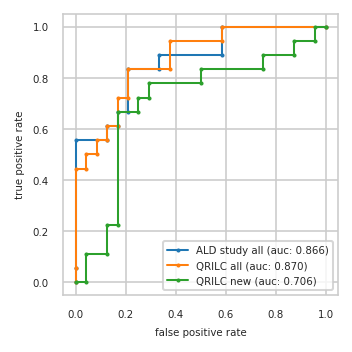

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.556     0.000 0.444     0.042 0.111
3          0.125 0.556     0.042 0.444     0.125 0.111
4          0.125 0.611     0.042 0.500     0.125 0.222
5          0.167 0.611     0.083 0.500     0.167 0.222
6          0.167 0.667     0.083 0.556     0.167 0.667
7          0.208 0.667     0.125 0.556     0.250 0.667
8          0.208 0.833     0.125 0.611     0.250 0.722
9          0.333 0.833     0.167 0.611     0.292 0.722
10         0.333 0.889     0.167 0.722     0.292 0.778
11         0.583 0.889     0.208 0.722     0.500 0.778
12         0.583 1.000     0.208 0.833     0.500 0.833
13         1.000 1.000     0.375 0.833     0.750 0.833
14           NaN   NaN     0.375 0.944     0.750 0.889
15           NaN   NaN     0.583 0.944     0.875 0.889
16           NaN   NaN     0.583 1.000     0.875 0.944
17           NaN   NaN     1.000 1.000     0.958 0.944
18           NaN   NaN       NaN   NaN     0.958 1.000
19           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P04075,Q9Y2T3;Q9Y2T3-3,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
1,Q9NRN5,B1AN99;P35030;P35030-2;P35030-3;P35030-4;P35030-5,None
2,P09486,P10636-2;P10636-6,None
3,K7ERG9;P00746,Q6EMK4,None
4,P14174,P61981,None
5,P10636-2;P10636-6,P04075,None
6,P61981,P14174,None
7,P18428,Q14894,None
8,Q6EMK4,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


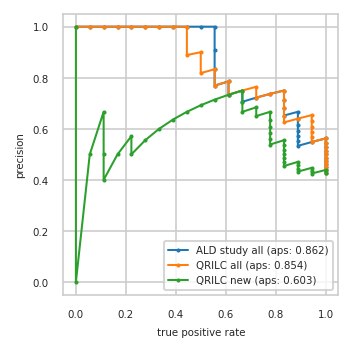

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.425 0.944
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.432 0.889
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.548 0.944     0.548 0.944     0.484 0.833
12         0.533 0.889     0.567 0.944     0.500 0.833
13         0.552 0.889     0.586 0.944     0.517 0.833
14         0.571 0.889     0.607 0.944     0.536 0.833
15         0.593 0.889     0.630 0.944     0.556 0.833
16         0.615 0.889     0.654 0.944     0.538 0.778
17         0.640 0.889     0.640 0.889     0.560 0.778
18         0.667 0.889     0.625 0.833     0.583 0.778
19         0.652 0.833     0.652 0.833     0.609 0.778
20         0.682 0.833     0.682 0.833     0.636 0.778
21         0.714 0.833     0.714 0.833     0.667 0.778
22         0.750 0.833     0.750 0.833     0.650 0.722
23         0.737 0.778     0.737 0.778     0.684 0.722
24         0.722 0.722     0.722 0.722     0.667 0.667
25         0.706 0.667     0.765 0.722     0.706 0.667
26         0.750 0.667     0.750 0.667     0.750 0.667
27         0.733 0.611     0.733 0.611     0.733 0.611
28         0.786 0.611     0.786 0.611     0.714 0.556
29         0.769 0.556     0.769 0.556     0.692 0.500
30         0.833 0.556     0.833 0.556     0.667 0.444
31         0.909 0.556     0.818 0.500     0.636 0.389
32         1.000 0.556     0.900 0.500     0.600 0.333
33         1.000 0.500     0.889 0.444     0.556 0.278
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


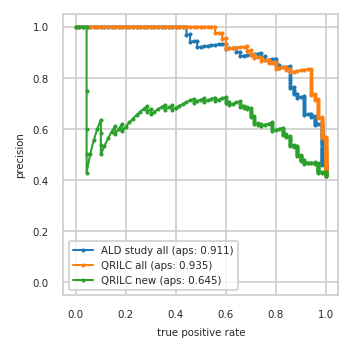

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


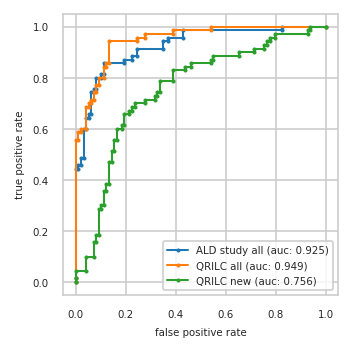

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}